In [59]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
import string
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data import random_split
import torch.nn.functional as F

import torchvision.transforms as transforms

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [61]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.characters = string.ascii_letters
        self.nchar = len(self.characters)+1
        self.data = os.listdir(data_dir)
        self.max_length = 12

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        pic = self.data[idx]
        img_path = os.path.join(self.data_dir, pic)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = Image.fromarray(img)
        img = self.transform(img)

        pic_target = pic[:-5]
        target = np.zeros((self.max_length, self.nchar), dtype=np.float32)
        
        for j, char in enumerate(pic_target[:self.max_length]):
            index = self.characters.find(char)
            target[j, index+1] = 1

        return img, target

10000 40000
tensor([[[1.0000, 0.9412, 0.9804,  ..., 0.9294, 1.0000, 1.0000],
         [0.9725, 1.0000, 0.9098,  ..., 1.0000, 1.0000, 1.0000],
         [0.9686, 1.0000, 0.9294,  ..., 1.0000, 0.9451, 0.9294],
         ...,
         [0.9922, 1.0000, 0.9294,  ..., 0.9216, 0.9373, 0.8824],
         [0.9529, 1.0000, 1.0000,  ..., 0.9412, 0.9490, 0.9961],
         [0.9373, 0.8941, 0.9216,  ..., 0.9961, 0.9059, 0.9608]]])
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0.

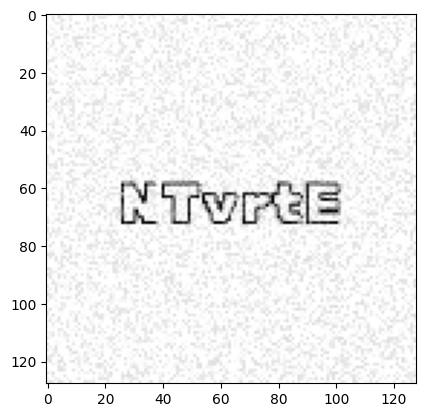

In [62]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.ToTensor(),  
])

dataset = CustomDataset("multichar", transform=transform)
train_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

print(len(train_dataset), len(test_dataset))

for img,label in train_dataset:
    print(img)
    print(label)
    plt.imshow(img[0],cmap='gray')
    plt.show()
    break

In [63]:
class MyNN(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(32,64,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((32, 12))

        self.rnn = nn.RNN(input_size=64*32, hidden_size=128,batch_first=True)
        self.fc = nn.Linear(128,53)

    def forward(self, x):

        batch_size = x.size(0)
        
        conv_output = self.features(x)
        conv_output = self.adaptive_pool(conv_output)
        
        conv_output = conv_output.permute(0, 3, 1, 2)
        sequence_length = conv_output.size(1)
        conv_output = conv_output.reshape(batch_size, sequence_length, -1)
        
        rnn_output, final_output = self.rnn(conv_output)
        logits = self.fc(rnn_output)
        
        return F.log_softmax(logits,dim=2)

In [64]:
epochs = 20
learning_rate = 0.001
model = MyNN()
model = model.to(device)
criterion = nn.CTCLoss(blank=0, reduction='mean',zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [65]:
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, targets in train_loader:
        
        images = images.to(device)
        targets = targets.to(device)
        batch_size = images.size(0)

        optimizer.zero_grad()

        log_probs = model(images)
        log_probs = log_probs.permute(1, 0, 2)
        
        input_lengths = torch.full((batch_size,), log_probs.size(0), dtype=torch.long, device=device)

        targets_indices = targets.argmax(dim=2)        
        target_lengths = [int((t > 0).sum().item()) for t in targets_indices]
        flat_targets = torch.cat([t[t > 0] for t in targets_indices])
        
        loss = criterion(log_probs, flat_targets, input_lengths, torch.tensor(target_lengths, dtype=torch.long, device=device))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} average loss: {avg_loss}")


Epoch 1 average loss: 2.463463105237522
Epoch 2 average loss: 0.44841647705140586
Epoch 3 average loss: 0.33134321811290596
Epoch 4 average loss: 0.2919138854922959
Epoch 5 average loss: 0.26363947202031984
Epoch 6 average loss: 0.23918805261865592
Epoch 7 average loss: 0.2204750256892591
Epoch 8 average loss: 0.2011880159449463
Epoch 9 average loss: 0.18599566887504757
Epoch 10 average loss: 0.16682637222230243
Epoch 11 average loss: 0.1488168165801813
Epoch 12 average loss: 0.13419493792441706
Epoch 13 average loss: 0.11984358642238398
Epoch 14 average loss: 0.10477841430650162
Epoch 15 average loss: 0.09092076660726017
Epoch 16 average loss: 0.07914619821424301
Epoch 17 average loss: 0.07054229660298877
Epoch 18 average loss: 0.06109309832627971
Epoch 19 average loss: 0.05401461184643709
Epoch 20 average loss: 0.048677008301495746


In [66]:
def clean_predictions(predictions):
    non_blank_predictions = predictions[predictions != 0]

    cleaned_predictions = []
    i = 0
    while i < len(non_blank_predictions):
        count = 1
        while i + 1 < len(non_blank_predictions) and non_blank_predictions[i] == non_blank_predictions[i + 1]:
            count += 1
            i += 1

        merged_count = (count // 2) + (count % 2)
        cleaned_predictions.extend([non_blank_predictions[i]] * merged_count)

        i += 1

    cleaned_predictions += [0] * (12 - len(cleaned_predictions))
    return torch.tensor(cleaned_predictions)

In [71]:
model.eval()

total_captchas = 0
correct_captchas = 0
total_characters = 0
correct_characters = 0

with torch.no_grad():
    for batch_features, batch_labels in train_loader:

        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        outputs = model(batch_features)

        predictions = torch.argmax(outputs, dim=2)
        target_indices = torch.argmax(batch_labels, dim=2)
        
        valid_char_mask = batch_labels.sum(dim=2) != 0

        cleaned_predictions = predictions.clone()
        for i in range(predictions.size(0)):
            cleaned_predictions[i] = clean_predictions(predictions[i])

        total_captchas += target_indices.size(0)

        correct_per_sequence = ((cleaned_predictions == target_indices) | ~valid_char_mask).all(dim=1)
        correct_captchas += correct_per_sequence.sum().item()

        total_characters += valid_char_mask.sum().item()
        correct_characters += ((cleaned_predictions == target_indices) & valid_char_mask).sum().item()

captcha_accuracy = 100 * correct_captchas / total_captchas
character_accuracy = 100 * correct_characters / total_characters

print(f"Captcha Accuracy: {captcha_accuracy:.2f}%")
print(f"Character Accuracy: {character_accuracy:.2f}%")

Captcha Accuracy: 82.51%
Character Accuracy: 90.07%


In [68]:
character = [
    '','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z',  'A', 'B', 'C', 'D',
    'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
    'Y', 'Z','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z',  'A', 'B', 'C', 'D',
    'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
    'Y', 'Z'
]

def findWord(k_ind):
    k_ind = k_ind.tolist()
    captcha = ''.join([character[k] for k in k_ind])
    return captcha

In [69]:
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features)
        predictions = torch.argmax(outputs, dim=2)
        
        for i in range(batch_features.size(0)):
            print(f"Prediction: {findWord(clean_predictions(predictions[i]))}, Label: {findWord(batch_labels[i].argmax(dim=1))}")

Prediction: AqeHpm, Label: AqeHpm
Prediction: PWqAZ, Label: PWqAZh
Prediction: zEvgKmd, Label: zEvgKmd
Prediction: LCKWU, Label: LCKWU
Prediction: huKKNX, Label: huKKNX
Prediction: IbofE, Label: IbofE
Prediction: wzERTE, Label: wzERTE
Prediction: jAJuoJq, Label: jAJuoJq
Prediction: HSEYh, Label: HnSEYh
Prediction: GPzNzQ, Label: GPzzNzQ
Prediction: IkEiv, Label: IPkEiv
Prediction: NrvVTW, Label: NrvVTW
Prediction: RetgiH, Label: RetgiH
Prediction: xtjDeL, Label: xtjDeL
Prediction: mExsW, Label: mExsW
Prediction: fyukKj, Label: fyukKj
Prediction: ltXPd, Label: ltXPd
Prediction: bpysV, Label: bWpysV
Prediction: EPJyL, Label: EPJyL
Prediction: tTBAarl, Label: tTBAajr
Prediction: lJTWo, Label: ElJTWro
Prediction: mLwtghV, Label: mLwtghV
Prediction: dagG, Label: dajgG
Prediction: dcfeGr, Label: dcfeGr
Prediction: lSCyG, Label: llSCyG
Prediction: tmIzZK, Label: tmIzZK
Prediction: WPbWctH, Label: WPbWctH
Prediction: JChEhJ, Label: JChEhJ
Prediction: QASWYL, Label: QASWYL
Prediction: NQRWt, La